# A Simple Autoencoder using Hi-C data

# 0. Hi-C class

In [1]:
"""
.. module:: Hic
   :synopsis: This module implements the matrix class.
"""

# Third-party modules
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import random as rd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random as rd
%matplotlib inline

reds = cm.get_cmap('Reds', 300)
white = np.array([1, 1, 1, 1])
newcmp = ListedColormap(np.vstack((white, reds(np.linspace(0, 1, 300)))))

class Hic:
    """
    .. class:: Hic
        This class groups informations about a Hi-C matrix.

    Attributes:
        sparse (Pandas DataFrame): A data frame containing the Hi-C sparse matrix.
        resolution (int): The resolution of the matrix.
        size (int):
        matrix (numpy array):
    """

    def __init__(self, filename, resolution):
        self.df = pd.read_csv(filename, sep='\t', header=None)
        self.df.columns = ['chr', 'base_1', 'base_2', 'value']
        self.resolution = resolution
        self.end = int(max(self.df['base_2']))
        self.size = int(self.end / self.resolution)
        self.matrix = None
        self.sub_matrices = None

    def set_matrix(self, added_lines, deleted_lines):
        """
            Create a sparse matrix in a very fast way using scipy.sparse module
            and convert it into a numpy array.
        """
        # All the values are stored in a numpy array
        # The matrix will be symetric, so the values must be added twice
        values = self.df.value
        data = np.array(values.append(values))
        # base_1 and base_2 columns must be converted to index by dividing by the resolution number
        # This step is necesary for the creation of the sparse matrix with scipy.sparse
        base_1_index = ((self.df.base_1 / self.resolution)+added_lines).astype(int)
        base_2_index = ((self.df.base_2 / self.resolution)+added_lines).astype(int)
        row = np.array(base_1_index.append(base_2_index))
        col = np.array(base_2_index.append(base_1_index))
        # Creation of the sparse matrix and conversion into a numpy array
        self.matrix = coo_matrix((data, (row, col)),
                                 shape=(self.size+added_lines+1, self.size+added_lines+1)
                                ).toarray()
        self.matrix = self.matrix[deleted_lines:, deleted_lines:]
        # Conversion in float32 format
        self.matrix = np.float32(self.matrix)
        # Logarithmic rescale
        self.matrix = np.log(self.matrix+1)
        # Rescaling of the values in range 0-1
        # (min-max scaling method)
        self.matrix = (self.matrix - self.matrix.min()) / (self.matrix.max() - self.matrix.min())
        # other method :
        # self.matrix = self.matrix / self.matrix.max()

    def print_matrix_informations(self):
        print("Chromosome(s) : {}".format(", ".join(self.df.chr.unique())))
        print("Shape of the Hi-C sparse matrix : {}*{}."
            .format(self.matrix.shape[0], self.matrix.shape[1]))
        print("Min={}, Max={}, Mean={:.2}"
            .format(self.matrix.min(), self.matrix.max(), self.matrix.mean()))

    def plot_matrix(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        ax.set_title('Hi-C matrix plot')
        im = ax.matshow(self.matrix, cmap=newcmp)
        fig.colorbar(im)

    def set_sub_matrices(self, nrow, ncol, nele=1):
        """
            Reshape of the sparse matrix in order to obtain N matrices of size nrow*ncol.

            Args:
                nrow (int): Number of rows for a sub-matrix
                ncol (int): Number of columns a sub-matrix
                nele (int): Number of element in a list (Default=1)
        """
        #self.sub_matrices = self.matrix.reshape(-1, nrow, ncol, nele)
        # Another less fancy method
        sub_matrices_list = []
        for i in range(0, self.matrix.shape[1], nrow):
            for j in range(0, self.matrix.shape[1], ncol):
                sub_matrix = self.matrix[i:i+nrow, j:j+ncol]
                sub_matrices_list.append(sub_matrix)
        self.sub_matrices = np.array(sub_matrices_list)
        self.sub_matrices = self.sub_matrices.reshape(-1, nrow, ncol, nele)

    def remove_white_sub_matrices(self):
        all_without_white = []
        for i in range(0, self.sub_matrices.shape[0]):
            if self.sub_matrices[i].sum() != 0:
                all_without_white.append(i)
        self.sub_matrices = self.sub_matrices[all_without_white]

    def print_sub_matrices_informations(self):
        print("{} sub-matrices of shape : {}*{}*{}"
            .format(self.sub_matrices.shape[0], self.sub_matrices.shape[1], self.sub_matrices.shape[2], self.sub_matrices.shape[3]))

    def plot_ten_sub_matrices(self):
        print("10 random sub-matrices :")
        plt.figure(figsize=(22, 4))
        for i in range(10):
            plt.subplot(2, 10, i+1)
            random_number = rd.randint(0, self.sub_matrices.shape[0]-1)
            # img_random = rd.randint(0, h.sub_matrices.shape[0])
            plt.imshow(self.sub_matrices[random_number, ..., 0], cmap=newcmp)
            plt.title("submatrix n°{}".format(random_number))

    def get_value(self, chr_num, base_1, base_2):
        """
            Search in a Pandas Dataframe (the Hi-C/NGS matrix) the unique row described
            by two given nucleotide bases and return the value corresponding.

            Args:
                chr_num (str): Name pf the chromosome.
                base_1 (int): Index of the first nucleotide base.
                base_2 (int): Index of the second nucleotide base.
            Returns:
                float: The corresponding value if the row exists or 0 if not.
        """
        # The row could be find by two combinations (base_1 base_2 or base_2 base_1)
        if not isinstance(base_1, int) or not isinstance(base_2, int):
            raise TypeError("Args must be integer.")

        filtered_matrix_1 = self.df[(self.df['chr'] == chr_num) &
                                    (self.df['base_1'] == base_1) &
                                    (self.df['base_2'] == base_2)]
        filtered_matrix_2 = self.df[(self.df['chr'] == chr_num) &
                                    (self.df['base_1'] == base_2) &
                                    (self.df['base_2'] == base_1)]

        # The row do exist in one of the two filtered data frames :
        if not filtered_matrix_1.empty:
            return float(filtered_matrix_1['value'])
        elif not filtered_matrix_2.empty:
            return float(filtered_matrix_2['value'])
        # The row does not exist :
        return 0

# 1. Dataset preparation

## 1.2 Numpy sparse Hi-C matrices

The Hic input files are stored in Pandas DataFrames.

We'll train the AE on chromosome 10 from **GSE63525 HUVEC** genome (`GSE63525_HUVEC_combined_30.hic.gz` file).
And test the AE on chromosome 20 from the same genome

In [2]:
resolution = 25000

Chromosome(s) : chr10
Shape of the Hi-C sparse matrix : 5400*5400.
Min=0.0, Max=1.0, Mean=0.023


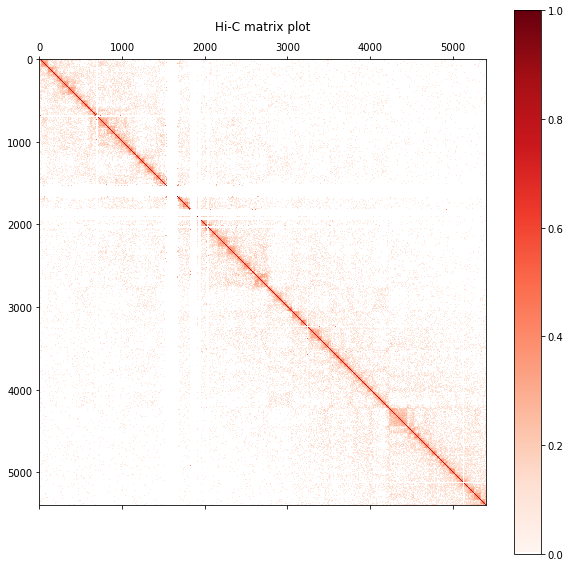

In [3]:
chr10_filename = '../../data/toy_example/2_sparse_matrices/hic/chr10.txt'
chr10 = Hic(chr10_filename, resolution)
added_lines = 0
deleted_lines = 21
chr10.set_matrix(added_lines, deleted_lines)
chr10.print_matrix_informations()
chr10.plot_matrix()

Chromosome(s) : chr20
Shape of the Hi-C sparse matrix : 2520*2520.
Min=0.0, Max=1.0, Mean=0.045


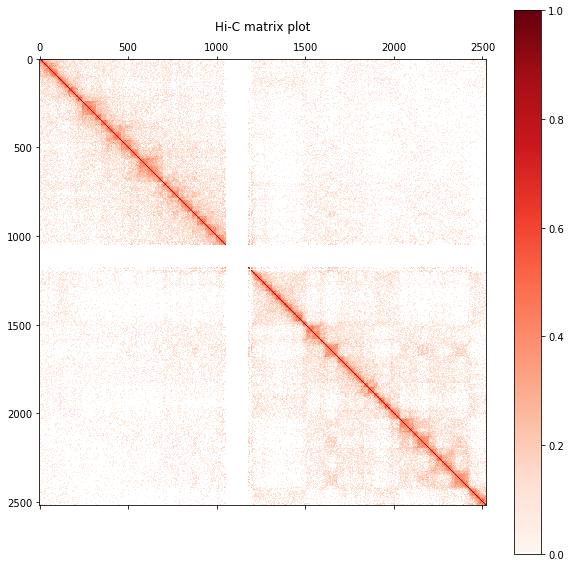

In [4]:
chr20_filename = '../../data/toy_example/2_sparse_matrices/hic/chr20.txt'
chr20 = Hic(chr20_filename, resolution)
added_lines = 1
deleted_lines = 0
chr20.set_matrix(added_lines, deleted_lines)
chr20.print_matrix_informations()
chr20.plot_matrix()

## 1.2 Sub-matrices

Shape of the sub-matrices : 30x30x1

In [5]:
N = 60

In [6]:
chr10.set_sub_matrices(N, N)
chr10.print_sub_matrices_informations()

8100 sub-matrices of shape : 60*60*1


10 random sub-matrices :


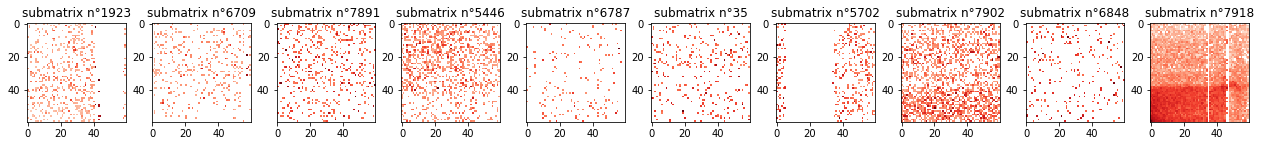

In [7]:
chr10.plot_ten_sub_matrices()

In [8]:
chr20.set_sub_matrices(N, N)
chr20.print_sub_matrices_informations()

1764 sub-matrices of shape : 60*60*1


10 random sub-matrices :


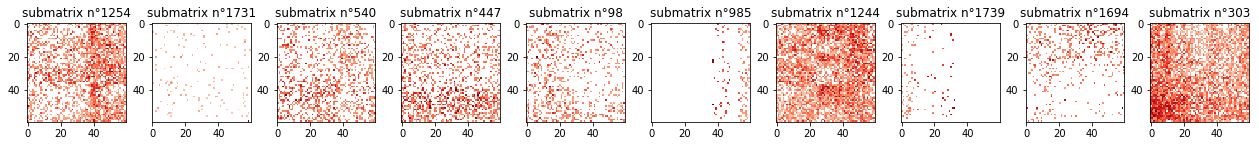

In [9]:
chr20.plot_ten_sub_matrices()

In [10]:
train = chr10.sub_matrices
test = chr20.sub_matrices

## 1.3 Training (80%) and validation (20%) sets

In [11]:
def display_shape(name, dataset):
    print("{} : {} sub-matrices of shape {}*{}*{}"
        .format(name, dataset.shape[0], dataset.shape[1], dataset.shape[2], dataset.shape[3]))

In [12]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train,
                                                             train, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [13]:
display_shape("Train set", train_X)
display_shape("Validation set", valid_X)

Train set : 6480 sub-matrices of shape 60*60*1
Validation set : 1620 sub-matrices of shape 60*60*1


# 2. Implementation of the Autoencoder

In [14]:
import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
import h5py

Using TensorFlow backend.


## 2.1 Parameters and building of the Model

In [15]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = N, N
input_img = Input(shape = (x, y, inChannel))

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #60 x 60 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 60 x 60 x 1
    return decoded

In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 60, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

## 2.2 Train the model

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Instructions for updating:
Use tf.cast instead.
Train on 6480 samples, validate on 1620 samples
Epoch 1/50
6480/6480 [==============================] - 130s 20ms/step - loss: 0.0097 - val_loss: 0.0039
Epoch 2/50
6480/6480 [==============================] - 124s 19ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 3/50
6480/6480 [==============================] - 122s 19ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 4/50
6480/6480 [==============================] - 121s 19ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 5/50
6480/6480 [==============================] - 121s 19ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 6/50
6480/6480 [==============================] - 121s 19ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 7/50
6480/6480 [==============================] - 121s 19ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 8/50
6480/6480 [==============================] - 121s 19ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 9/50
6480/6480 [==============================] - 121s 19m

## 2.3 Training and Validation Loss Plot

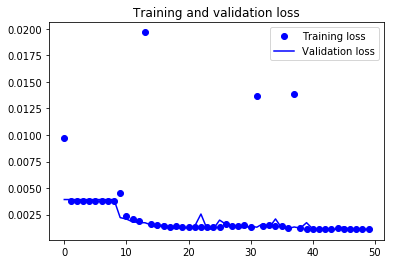

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
pred = autoencoder.predict(test)

In [312]:
l = [85, 86, 258, 311, 312, 313, 502, 624, 908, 1203]
def plot_ten_submatrices(dataset):
    plt.figure(figsize=(22, 4))
    for i, sub_matrix in enumerate(l):
        plt.subplot(2, 10, i+1)
        # img_random = rd.randint(0, h.sub_matrices.shape[0])
        plt.imshow(dataset[sub_matrix, ..., 0], cmap=newcmp)
        plt.title("submatrix n°{}".format(sub_matrix))

Test set : 1764 sub-matrices of shape 60*60*1


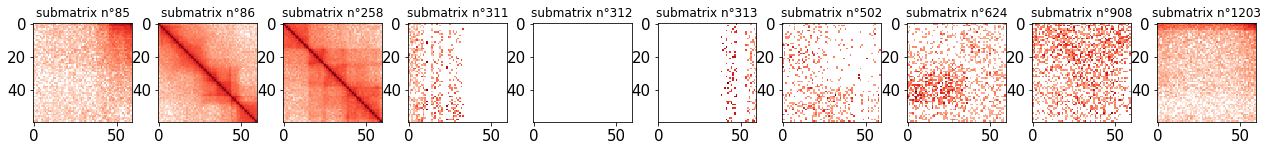

In [313]:
plot_ten_submatrices(test)

Pred set : 1764 sub-matrices of shape 60*60*1


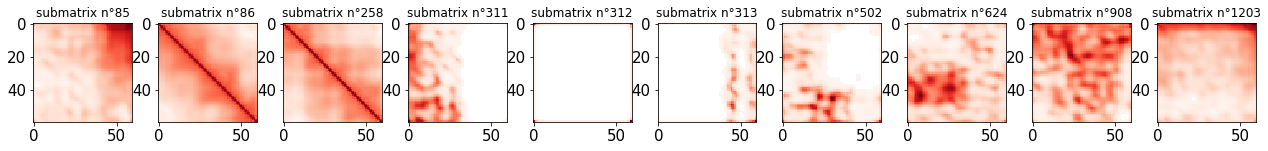

In [314]:
plot_ten_submatrices(pred)

## 2.4 Reconstruction of the predicted Hi-C matrix

In [36]:
nb_sub_matrices = int(chr20.matrix.shape[0]/N)
del reconstructed_matrix
j = 1
for _, matrix in enumerate(pred):
    if j == nb_sub_matrices:
        try:
            line = np.concatenate((line, matrix), axis=1)
            reconstructed_matrix = np.concatenate((reconstructed_matrix, line), axis=0)
        except:
            reconstructed_matrix = line
    
        j = 1
        del line
    else:
        try:
            line = np.concatenate((line, matrix), axis=1)
        except:
            line = matrix     
        j += 1
reconstructed_matrix = reconstructed_matrix.reshape(reconstructed_matrix.shape[0], reconstructed_matrix.shape[1])

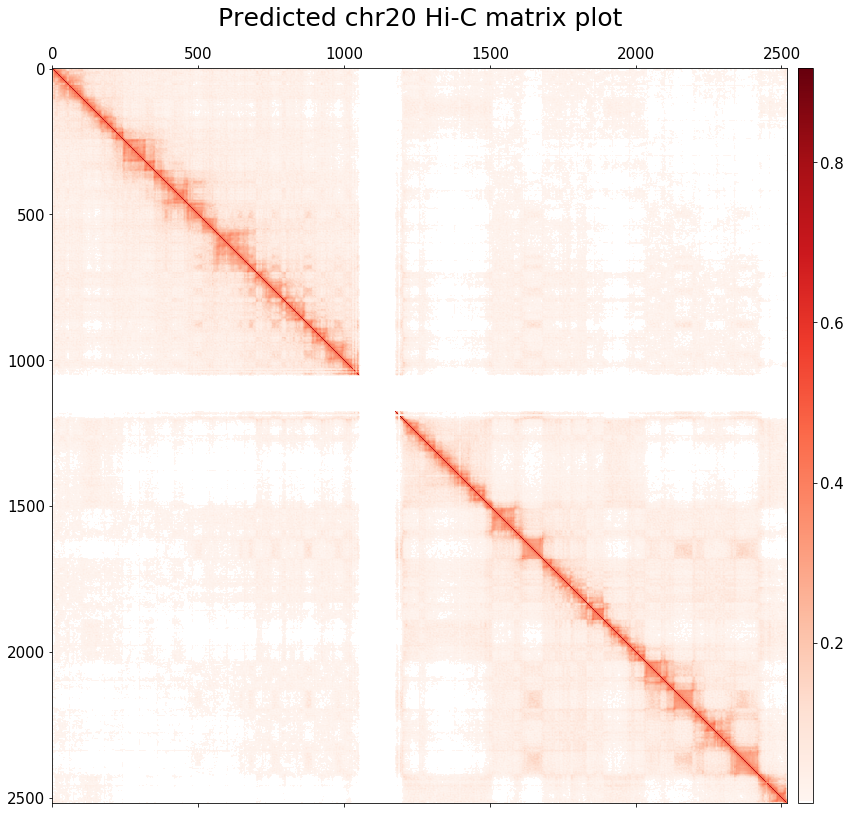

In [305]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111,aspect = 'equal')
im = ax.matshow(reconstructed_matrix, cmap=newcmp)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(im, cax=cax)
plt.subplots_adjust(left=0.07, bottom=0, right=0.95, top=0.91, wspace=0, hspace=0)
ax.set_title('Predicted chr20 Hi-C matrix plot', fontsize=25)
fig.savefig('chr20_pred.png')

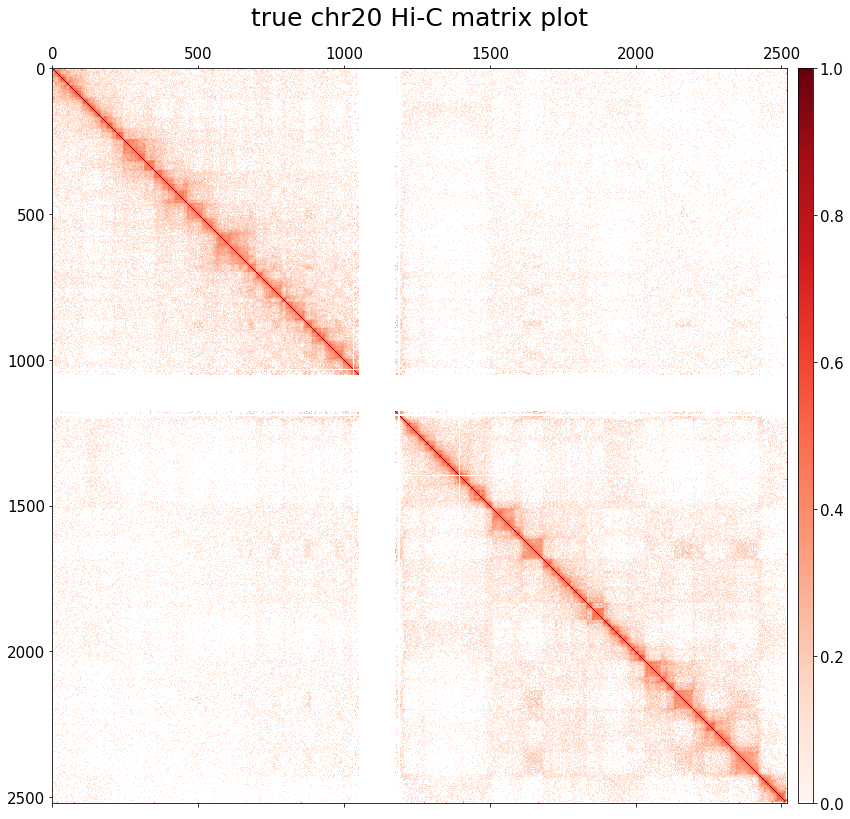

In [311]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)

chr_name = "chr20"
matrix_type = "true"
matrix = chr20.matrix

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(111,aspect = 'equal')
im = ax.matshow(matrix, cmap=newcmp)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(im, cax=cax)
plt.subplots_adjust(left=0.07, bottom=0, right=0.95, top=0.91, wspace=0, hspace=0)
ax.set_title('{} {} Hi-C matrix plot'.format(matrix_type, chr_name), fontsize=25)
fig.savefig('{}_{}.png'.format(matrix_type,chr_name))